# Training a GAP model

## steps
    1. generate a small dataset of water structures 
        - use CP2K if you havea access to it
        - otherwise: use any simple potential implemented in ASE, just for trying this out I have used EMT here
    1. generate e0 values
    1. separate a training and a validation dataset
    1. **train the model**
    1. look at the outcome of the model
    
## here we will fit twice, to see the difference between a 2b-only and a 2b+3b fit

In [2]:
# general imports 
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

# ase imports
import ase.io
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
# for MD
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

In [3]:
# helper functions
def make_water(density, super_cell=[3, 3, 3]):
    """ Geenrates a supercell of water molecules with a desired density.
        Density in g/cm^3!!!"""
    h2o = molecule('H2O')
    a = np.cbrt((sum(h2o.get_masses()) * units.m ** 3 * 1E-6 ) / (density * units.mol))
    h2o.set_cell((a, a, a))
    h2o.set_pbc((True, True, True))
    #return cp(h2o.repeat(super_cell))
    return h2o.repeat(super_cell)

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

## generating data only with ASE, using the EMT calculator

This is only for the demonstration of how to do it, this run is will be done very fast. There is no practical use of the data beyond lerning the use teach_sparse, quip, etc. with it.

In [4]:
# Running MD with ASE's EMT

from ase.calculators.emt import EMT
calc = EMT()

T = 150  # Kelvin

# Set up a grid of water
water = make_water(1.0, [3, 3, 3])
water.set_calculator(calc)

# We want to run MD using the Langevin algorithm
# with a time step of 1 fs, the temperature T and the friction
# coefficient to 0.002 atomic units.
dyn = Langevin(water, 1 * units.fs, T * units.kB, 0.0002)

def printenergy(a=water):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

dyn.attach(printenergy, interval=5)

# We also want to save the positions of all atoms after every 5th time step.
traj = Trajectory('dyn_emt.traj', 'w', water)
dyn.attach(traj.write, interval=5)

# Now run the dynamics
printenergy(water)
dyn.run(600)   # CHANGE THIS IF YOU WANT LONGER/SHORTER RUN

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.820eV  Ekin = 0.053eV (T=414K)  Etot = 0.874eV
Energy per atom: Epot = 0.660eV  Ekin = 0.208eV (T=1610K)  Etot = 0.868eV
Energy per atom: Epot = 0.632eV  Ekin = 0.224eV (T=1734K)  Etot = 0.856eV
Energy per atom: Epot = 0.869eV  Ekin = 0.005eV (T= 39K)  Etot = 0.874eV
Energy per atom: Epot = 0.781eV  Ekin = 0.088eV (T=681K)  Etot = 0.869eV
Energy per atom: Epot = 0.756eV  Ekin = 0.117eV (T=904K)  Etot = 0.873eV
Energy per atom: Epot = 0.707eV  Ekin = 0.163eV (T=1263K)  Etot = 0.870eV
Energy per atom: Epot = 0.702eV  Ekin = 0.159eV (T=1234K)  Etot = 0.861eV
Energy per atom: Epot = 0.865eV  Ekin = 0.008eV (T= 63K)  Etot = 0.873eV
Energy per atom: Epot = 0.712eV  Ekin = 0.153eV (T=1180K)  Etot = 0.865eV
Energy per atom: Epot = 0.677eV  Ekin = 0.191eV (T=1481K)  Etot = 0.868eV
Energy per atom: Epot = 0.809eV  Ekin = 0.062

True

In [23]:
# wrap and save traj in .xyz --- the .traj is a non human readable database file, xyz is much better
out_traj = ase.io.read('dyn_emt.traj', ':')
for at in out_traj:
    at.wrap()
    if 'momenta' in at.arrays: del at.arrays['momenta']
ase.io.write('dyn_emt.xyz', out_traj, 'xyz')

## get e0 for H and O - energies of the isolated atoms

This is the energy of the isolated atom, will be in the teach_sparse string in the following format: `e0={H:energy:O:energy}`

In [11]:
isolated_H = Atoms('H', calculator=EMT(), cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', calculator=EMT(), cell=[20, 20, 20], pbc=True)

print('e0_H:',isolated_H.get_potential_energy())
print('e0_O:',isolated_O.get_potential_energy())

# this made the e0 string be the following: e0={H:3.21:O:4.6}

e0_H: 3.21
e0_O: 4.6


## separate the dataset into a training and a validation set

As we have 120 frames from the 600fs MD, I will do it 60,60 with taking even and odd frames for the two

In [24]:
ase.io.write('train.xyz', out_traj[0::2] )  
ase.io.write('validate.xyz', out_traj[1::2])

In [16]:
out_traj[0].arrays.keys()

dict_keys(['numbers', 'positions'])

## implement our own GP for energy training

Here we will begin defining our training to turn the original data into a training process that can predict energy and force like the GAP program.

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

Optimal hyperparameters:  [1000.0, 15.040639605987117, 0.03098019131404234]
Predicted Energy:
[53.7895281  63.11654555 65.91969763 58.24597046 58.26704243 65.14252322
 65.87998811 59.15208369 59.5008653  62.47946728 60.66984364 62.20578862
 58.74465686 56.94144998 56.29429463 57.07948574 56.01194325 57.59380108
 48.7054532  48.34513045 45.71088628 46.02181171 47.56674807 47.37324742
 44.60160549 39.29774132 40.13236066 39.08557363 38.37587757 39.85398357
 38.6451944  39.07613887 37.47024122 39.2717969  38.65055228 34.22675117
 33.99976727 32.11132886 30.79986015 29.61847975 33.75126771 33.29286218
 35.31232763 34.87409593 37.09773247 37.31425664 35.91402879 33.41046048
 30.14696438 34.39008595 34.36708888 36.19286819 36.04734115 34.02069282
 32.98730025 32.10981984 33.73376379 33.39275987 36.30194805 36.23558446]


/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


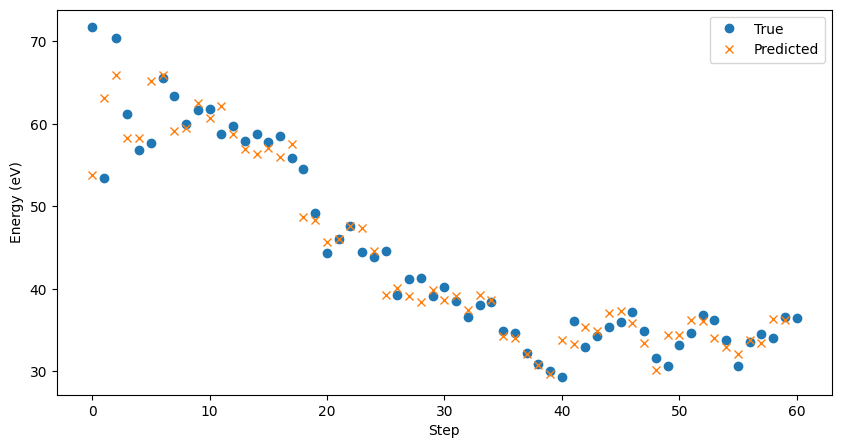

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from skopt.space import Real
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize

X_obj = ase.io.read('train.xyz', ':')
validate_data = ase.io.read('validate.xyz', ':')
X_train = [at.get_positions().flatten() for at in ase.io.read('train.xyz', ':')]
y_energy_train = [at.get_potential_energy() for at in X_obj]
y_force_train = [at.get_forces().flatten() for at in X_obj]

# Extract the features for validation
X_validate = [at.get_positions().flatten() for at in validate_data]
y_energy_val = [at.get_potential_energy() for at in validate_data]

def objective_function(params):
    constant_value, rbf_length_scale, noise_level = params

    # Define the kernel with the current hyperparameters
    kernel_energy = ConstantKernel(constant_value, (1e-3, 1e3)) * RBF(rbf_length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
    
    # Initialize and train the Gaussian Process model
    gp_energy = GaussianProcessRegressor(kernel=kernel_energy)
    gp_energy.fit(X_train, y_energy_train)

    # Predict on a validation set and calculate MSE
    y_pred = gp_energy.predict(X_validate)
    mse = mean_squared_error(y_energy_val, y_pred)
    return mse


space = [
    Real(1e-3, 1e3, name='constant_value'),
    Real(1e-2, 1e2, name='rbf_length_scale'),
    Real(1e-10, 1, name='noise_level')
]

result = gp_minimize(
    objective_function,               # the function to minimize
    space,                            # the bounds on each dimension of x
    acq_func="EI",                    # the acquisition fsunction
    n_calls=50,                       # the number of evaluations of f
    n_random_starts=10,               # the number of random initialization points
    random_state=123                  # the random seed
)

# Optimal hyperparameters
print("Optimal hyperparameters: ", result.x)

kernel_energy = ConstantKernel(result.x[0], (1e-3, 1e3)) * RBF(result.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result.x[2])

gp_energy = GaussianProcessRegressor(kernel=kernel_energy)
gp_energy.fit(X_train, y_energy_train)

y_energy_pred = gp_energy.predict(X_validate)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_energy_train)), y_energy_train, 'o')
plt.plot(range(len(y_energy_pred)), y_energy_pred, 'x')
legend = ['True', 'Predicted']
plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV)')



/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

Text(0, 0.5, 'Energy (eV/A)')

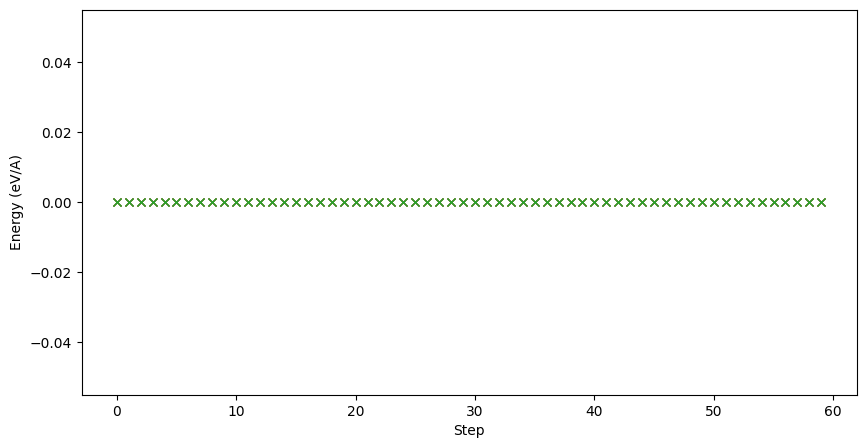

In [47]:
y_force_val = [at.get_forces().flatten() for at in validate_data]

##TODO: fix optimization of hyperparameters for force prediction

def objective_function(params):
    constant_value, rbf_length_scale, noise_level = params

    # Define the kernel with the current hyperparameters
    kernel_force = ConstantKernel(constant_value, (1e-3, 1e3)) * RBF(rbf_length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
    
    # Initialize and train the Gaussian Process model
    gp_force = GaussianProcessRegressor(kernel=kernel_force)
    gp_force.fit(X_train, y_force_train)

    # Predict on a validation set and calculate MSE
    y_pred = gp_force.predict(X_validate)
    mse = mean_squared_error(y_force_val, y_pred)

    return mse

space = [
    Real(1e-5, 1e5, name='constant_value'),
    Real(1e-5, 1e5, name='rbf_length_scale'),
    Real(1e-10, 1, name='noise_level')
]

result = gp_minimize(
    objective_function,               # the function to minimize
    space,                            # the bounds on each dimension of x
    acq_func="EI",                    # the acquisition fsunction
    n_calls=50,                       # the number of evaluations of f
    n_random_starts=10,               # the number of random initialization points
    random_state=123                  # the random seed
)


# Define the kernel for force prediction
kernel_force = ConstantKernel(result.x[0], (1e-3, 1e3)) * RBF(result.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result.x[2])


gp_force = GaussianProcessRegressor(kernel=kernel_force)

y_force_train_reshaped = np.concatenate(y_force_train).reshape(-1, len(X_train[0]))
gp_force.fit(X_train, y_force_train_reshaped)

y_force_pred = gp_force.predict(X_validate)

# Visualize the predicted energy and force
plt.figure(figsize=(10, 5))
#plt.plot(range(len(y_force_val)), y_force_val, 'o')
plt.plot(range(len(y_force_pred)), y_force_pred, 'x')
legend = ['True', 'Predicted']
#plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV/A)')
